In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# DB SCAN

def euclidean(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def region_query(X, point_idx, eps):
    neighbors = []
    for i in range(len(X)):
        if euclidean(X[point_idx], X[i]) <= eps:
            neighbors.append(i)
    return neighbors

def expand_cluster(X, labels, point_idx, neighbors, cluster_id, eps, min_pts):
    labels[point_idx] = cluster_id
    i = 0
    while i < len(neighbors):
        neighbor_idx = neighbors[i]
        if labels[neighbor_idx] == -1:  # previously marked as noise
            labels[neighbor_idx] = cluster_id
        elif labels[neighbor_idx] == 0:  # unvisited
            labels[neighbor_idx] = cluster_id
            neighbor_neighbors = region_query(X, neighbor_idx, eps)
            if len(neighbor_neighbors) >= min_pts:
                neighbors += neighbor_neighbors
        i += 1

def dbscan(X, eps, min_pts):
    labels = [0] * len(X)  # 0 = unvisited, -1 = noise
    cluster_id = 0

    for point_idx in range(len(X)):
        if labels[point_idx] != 0:
            continue
        neighbors = region_query(X, point_idx, eps)
        if len(neighbors) < min_pts:
            labels[point_idx] = -1  # mark as noise
        else:
            cluster_id += 1
            expand_cluster(X, labels, point_idx, neighbors, cluster_id, eps, min_pts)

    return labels

In [3]:
# fetching data
df = pd.read_csv("/content/drive/MyDrive/ML/Dataset/synthetic_crime_data.csv")

# Convert 'Date' to a numerical timestamp
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].astype('int64') // 10**9  # Convert to seconds

# Convert 'Time' to seconds from midnight
df['Time'] = pd.to_timedelta(df['Time']).dt.total_seconds()

# Encode 'Crime Type' as numerical category
df['Crime Type'] = df['Crime Type'].astype('category').cat.codes

# Drop non-numeric or irrelevant columns
df = df.drop(columns=['Incident ID', 'Location Description'])

df.head()

,Date,Time,Crime Type,Latitude,Longitude
0,1709251200,21146.0,4,-20.497564,94.488524
1,1710201600,9642.0,4,73.983723,163.824695
2,1733702400,3264.0,3,77.843518,-179.386456
3,1717286400,52654.0,1,71.916409,113.791924
4,1742947200,59100.0,2,15.037732,101.628490


In [4]:
X = df.to_numpy()
labels = np.array(dbscan(X, eps=0.1, min_pts=8))

<ipython-input-5-a7c6f85bf9a2>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


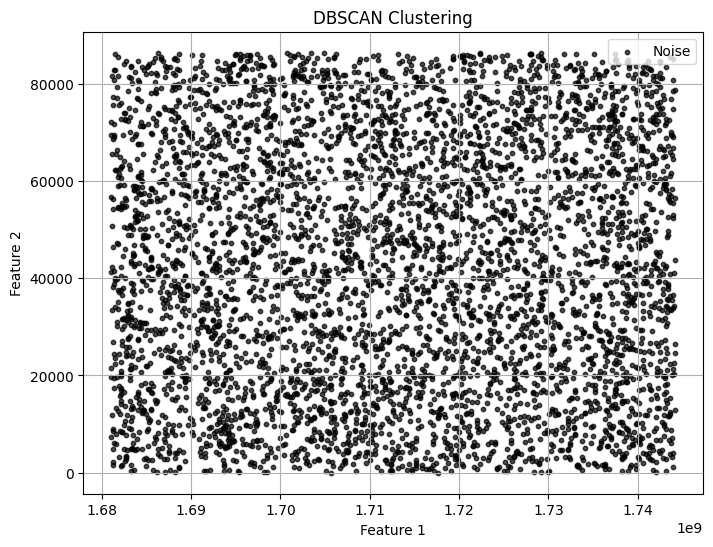

In [5]:
# Plotting only works in 2D, so X should have 2 columns
plt.figure(figsize=(8, 6))

# Unique clusters
unique_labels = set(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for label in unique_labels:
    # -1 means noise
    if label == -1:
        color = 'k'
        label_name = 'Noise'
    else:
        color = colors(label)
        label_name = f'Cluster {label}'

    plt.scatter(
        X[labels == label, 0],
        X[labels == label, 1],
        s=10,
        c=[color],
        label=label_name,
        alpha=0.7
    )

plt.title("DBSCAN Clustering")
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()